In [282]:
# working directory
import os

# importing necessary modules
import random
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import HTML
import torch 


In [283]:
# setting seeds
random.seed(42)
np.random.seed(42)

## Data

In [284]:
# reading the dataset
df = pd.read_csv('data/mushroom.csv')
# randomizing the dataset
df = df.sample(frac=1.0)
# check the class distribution
print(df['edible'].value_counts())
df.head()

e    4208
p    3916
Name: edible, dtype: int64


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
1971,e,f,f,n,f,n,f,w,b,h,...,f,w,w,p,w,o,e,n,s,g
6654,p,f,s,e,f,y,f,c,n,b,...,s,p,p,p,w,o,e,w,v,l
5606,p,x,y,n,f,f,f,c,n,b,...,s,w,p,p,w,o,e,w,v,l
3332,e,f,y,g,t,n,f,c,b,n,...,s,g,p,p,w,o,p,n,y,d
6988,p,f,s,e,f,s,f,c,n,b,...,s,p,p,p,w,o,e,w,v,l


### Preprocess

In [285]:
# splitting our df
X = df.copy().drop('edible', axis=1)
# edible -> 0, poisonous -> 1
y = df.copy()['edible'].astype('category').cat.codes

# One-hot
X = pd.get_dummies(X, drop_first=True)
y.head()

1971    0
6654    1
5606    1
3332    0
6988    1
dtype: int8

In [286]:
# coding a class for this
class MushroomBandit:
    
    # initializing
    def __init__(self, X, y,n_weight_sampling=2):
        self.epsilon = 0
        self.net = None
        self.loss, self.optimizer = None, None
        self.bufferX, self.bufferY = [], []
        self.cum_regrets = [0]
        self.n_weight_sampling = n_weight_sampling

    def get_reward(self,eaten,poison):
        if eaten:
            if poison:
                # poison = 1, poisonous
                return 5 if np.random.rand() > 0.5 else -35
            else:
                return 5
        else:
            return 0
    
    def calculate_regret(self, reward, poison):
        if poison:
            return 0 - reward
        else:
            return 5 - reward

    def init_buffer(self):
        for i in np.random.choice(range(len(X)), 4096):
            eaten = 1 if np.random.rand() > 0.5 else 0
            self.bufferX.append(X[i])
            self.bufferY.append(self.get_reward(eaten, y[i]))
        
    # function to get which mushrooms will be eaten
    def eat_mushrooms(self, mushroom_idx):
        context, poison = X[mushroom_idx], y[mushroom_idx]
        tensor_context = torch.from_numpy(context).type(torch.FloatTensor)

        if np.random.rand() < self.epsilon:
            eaten = int(np.random.rand() < 0.5)
        else:
            with torch.no_grad():
                predict_reward = sum([self.net(tensor_context) for _ in range(self.n_weight_sampling)]).item()
                eaten = 0 if predict_reward > 0 else 1
        
        agent_reward = self.get_reward(eaten, poison)

        # Get rewards and update buffer
        self.bufferX.append(context)
        self.bufferY.append(agent_reward)

        # Calculate regret
        regret = self.calculate_regret(agent_reward,poison)
        self.cum_regrets.append(self.cum_regrets[-1]+regret)

    # Update buffer
    def update(self, mushroom):
        self.eat_mushrooms(mushroom)
        # idx pool
        l = len(self.bufferX)
        idx_pool = range(l) if l >= 4096 else ((int(4096//l) + 1)*list(range(l)))
        idx_pool = np.random.permutation(idx_pool[-4096:])
        context_pool = torch.Tensor([self.bufferX[i] for i in idx_pool])
        reward_pool = torch.Tensor([self.bufferY[i] for i in idx_pool])
        for i in range(0, 4096, 64):
            self.loss_step(context_pool[i:i+64], reward_pool[i:i+64], i//64)
        
    
    def loss_step(self, x, y):
        raise NotImplementedError

In [287]:
import torch.nn as nn
import torch.optim as optim
def simple_net(inputs):
    net = nn.Sequential(
        nn.Linear(inputs, 100), nn.ReLU(),
        nn.Linear(100, 100), nn.ReLU(),
        nn.Linear(100, 1))
    return net

In [288]:
# Class for Greedy agents
class Greedy(MushroomBandit):
    def __init__(self, epsilon=0, lr=2e-5, **kwargs):
        super().__init__(**kwargs)
        self.n_weight_sampling = 1
        self.epsilon = epsilon
        self.net = simple_net(X.shape[1])
        self.optimizer = optim.SGD(self.net.parameters(), lr=lr)
        self.mse = lambda x, y:((x-y)**2).sum()/64
        
    def loss_step(self, x, y, batch_id):
        self.net.zero_grad()
        loss = self.mse(self.net.forward(x), y)
        loss.backward()
        self.optimizer.step()

In [289]:
X = X.to_numpy()
y = y.to_numpy()

In [290]:
rate=1e-5
mnets = {'Greedy':Greedy(X=X,y=y,lr=rate,epsilon=0),
         'Greedy 1%':Greedy(X=X,y=y,lr=rate, epsilon=0.01),
         'Greedy 5%':Greedy(X=X,y=y,lr=rate, epsilon=0.05)}

In [291]:
NB_STEPS = 1000
torch.autograd.set_detect_anomaly(True)

for name, net in mnets.items():
    net.init_buffer()
for step in tqdm(range(NB_STEPS)):
    mushroom = np.random.randint(len(X))
    for name, net in mnets.items():
        net.update(mushroom)

100%|██████████| 1000/1000 [17:14<00:00,  1.03s/it]


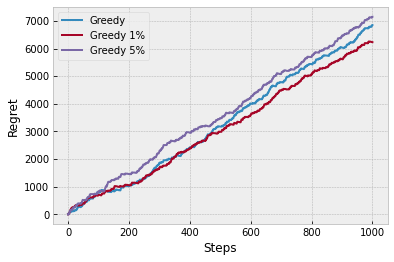

In [292]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots() 

for name, net in mnets.items():
    ax.plot(net.cum_regrets, label=name)
ax.set_xlabel('Steps') 
ax.set_ylabel('Regret') 
ax.legend()
plt.show()
